In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

25200


In [2]:
from matplotlib.colors import LogNorm
from ImageAnalysis3.figure_tools import _dpi,_single_col_width,_double_col_width,_single_row_height,_ref_bar_length, _ticklabel_size,_ticklabel_width,_font_size
plt.style.use('dark_background')

figure_master_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220803-Figures'
contact_figure_folder = os.path.join(figure_master_folder, 'LongRangeContacts')
if not os.path.exists(contact_figure_folder):
    print(f"Create contact_figure_folder: {contact_figure_folder}")
    os.makedirs(contact_figure_folder)
else:
    print(f"Use contact_figure_folder: {contact_figure_folder}")
comp_figure_folder = os.path.join(figure_master_folder, 'AB_compartments')
if not os.path.exists(comp_figure_folder):
    print(f"Create comp_figure_folder: {comp_figure_folder}")
    os.makedirs(comp_figure_folder)
else:
    print(f"Use comp_figure_folder: {comp_figure_folder}")

Use contact_figure_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220803-Figures\LongRangeContacts
Use comp_figure_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220803-Figures\AB_compartments


## Load codebook

In [3]:
merged_data_folder = r'\\crick\SSD_0\Shiwei\DNA_MERFISH_analysis\20220402plus0316_MERFISH'
print(merged_data_folder)
# 
postanalysis_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis'
print(postanalysis_folder)

\\crick\SSD_0\Shiwei\DNA_MERFISH_analysis\20220402plus0316_MERFISH
\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis


In [4]:
import pandas as pd
codebook = pd.read_csv(os.path.join(merged_data_folder, 'merged_codebook_w_celltype.csv'))
bit_columns = [_n for _n in codebook.columns if 'NDB' in _n]

## Load coordinates for subtypes

In [5]:
class_2_zxysDict = np.load(os.path.join(merged_data_folder, 'merged_class_2_chr_zxys.pkl'), allow_pickle=True)

In [6]:
np.sum([len(_v) for _k,_v in class_2_zxysDict.items()])

22855

# 1. calculate overall contact prob

In [8]:
from ImageAnalysis3.structure_tools.distance import Chr2ZxysList_2_summaryDist_by_key,Chr2ZxysList_2_summaryDict

In [9]:
reload(ia.structure_tools.distance)

<module 'ImageAnalysis3.structure_tools.distance' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\structure_tools\\distance.py'>

In [11]:
subclass_2_contact_filename = os.path.join(postanalysis_folder, 'subclass_2_contactDict_600.pkl')
print(subclass_2_contact_filename)

if os.path.exists(subclass_2_contact_filename):
    print("Loading")
    subclass_2_contactDict = np.load(subclass_2_contact_filename, allow_pickle=True)
else:
    # calculate prob
    subclass_2_contactDict = {}
    for _subclass in class_2_zxysDict:
        subclass_2_contactDict[_subclass] = Chr2ZxysList_2_summaryDict(
            class_2_zxysDict[_subclass], 
            total_codebook=codebook, 
            function=ia.structure_tools.distance.contact_prob,
            num_threads=44, verbose=True)
    print(f"Saving to: {subclass_2_contactDict}")
    pickle.dump(subclass_2_contactDict, open(subclass_2_contact_filename, 'wb'))

\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis\subclass_2_contactDict_600.pkl
-- preparing chr_2_zxys from 2533 cells in 0.331s.
-- summarize 231 inter-chr distances with 44 threads in 109.768s.
-- preparing chr_2_zxys from 1663 cells in 0.210s.
-- summarize 231 inter-chr distances with 44 threads in 77.955s.
-- preparing chr_2_zxys from 2358 cells in 0.306s.
-- summarize 231 inter-chr distances with 44 threads in 97.712s.
-- preparing chr_2_zxys from 1606 cells in 0.197s.
-- summarize 231 inter-chr distances with 44 threads in 73.816s.
-- preparing chr_2_zxys from 833 cells in 0.095s.
-- summarize 231 inter-chr distances with 44 threads in 90.534s.
-- preparing chr_2_zxys from 1289 cells in 0.268s.
-- summarize 231 inter-chr distances with 44 threads in 128.855s.
-- preparing chr_2_zxys from 457 cells in 0.170s.
-- summarize 231 inter-chr distances with 44 threads in 42.681s.
-- preparing chr_2_zxys from 3078 cells in 1.470s.
-- summarize 231 inter-chr distances

<IPython.core.display.Javascript object>


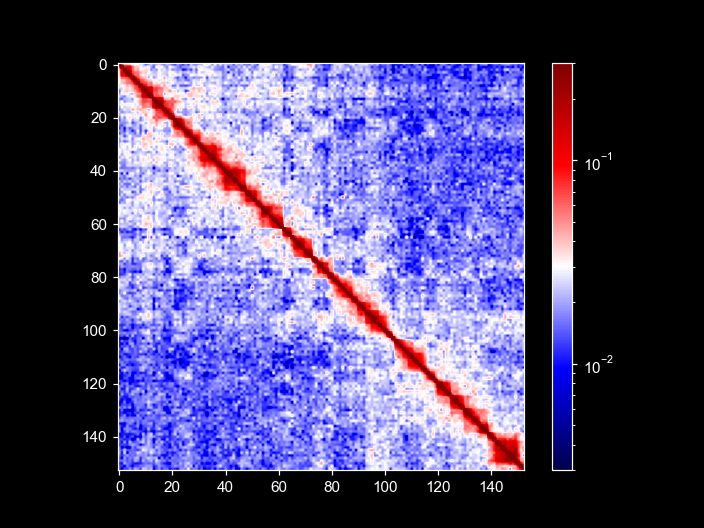

In [38]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots()
_pf = ax.imshow(subclass_2_contactDict['L2/3 IT'][('cis_1')], norm=LogNorm(vmin=3e-3, vmax=3e-1), cmap='seismic')
plt.colorbar(_pf)

## 1.2 Ensemble average

In [ ]:
reload(ia.structure_tools.distance)
from ImageAnalysis3.structure_tools.distance import Chr2ZxysList_2_summaryDist_by_key,Chr2ZxysList_2_summaryDict

In [16]:
ensemble_contact_filename = os.path.join(postanalysis_folder, 'ensemble_contactDict_600.pkl')
print(ensemble_contact_filename)

if os.path.exists(ensemble_contact_filename):
    print("Loading")
    ensemble_contactDict = np.load(ensemble_contact_filename, allow_pickle=True)

else:
    # summarize all zxy_dicts
    all_zxys_dicts = []
    for _subclass, _zxysDicts in class_2_zxysDict.items():
        all_zxys_dicts.extend(_zxysDicts)
    ensemble_contactDict = Chr2ZxysList_2_summaryDict(
        all_zxys_dicts, 
        total_codebook=codebook, 
        function=ia.structure_tools.distance.contact_prob,
        parallel=True,
        num_threads=15, verbose=True) # change to 8 threads because running 44 threads directly crashed RAM
    print(f"Saving to: {ensemble_contact_filename}")
    pickle.dump(ensemble_contactDict, open(ensemble_contact_filename, 'wb'))

\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis\ensemble_contactDict_600.pkl
-- preparing chr_2_zxys from 22855 cells in 7.061s.
-- summarize 231 inter-chr distances with 15 threads in 1501.755s.
Saving to: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis\ensemble_contactDict_600.pkl


# 2 Ensemble AB calling

In [18]:
# assemble trans-chr matrix without cis
from ImageAnalysis3.structure_tools import distance
from astropy.convolution import convolve, Gaussian2DKernel
from sklearn.decomposition import PCA

_mat, _chr_edges, _chr_names = distance.assemble_ChrDistDict_2_Matrix(
    ensemble_contactDict, codebook, use_cis=False, use_trans=False, sort_by_region=False)
chr_2_indices, chr_2_orders = distance.Generate_PlotOrder(codebook, codebook, sort_by_region=False)

# normalize by chr
_normed_mat = _mat.copy()
chr_2_meanContact = {}
for _chr,_inds in chr_2_indices.items():
    chr_2_meanContact[_chr] = np.nanmean(_mat[_inds])
    _normed_mat[_inds] *= 1 / chr_2_meanContact[_chr]
    _normed_mat[:,_inds] *= 1 / chr_2_meanContact[_chr]
_normed_mat = _normed_mat / np.nanmean(_normed_mat)
# correlation
_mat_df = pd.DataFrame(_normed_mat)
mat_corr_df = _mat_df.corr()

# norm corr_mat
_corr_mat = mat_corr_df.values[:-1,:-1]
_corr_mat[np.diag_indices(len(_corr_mat))] = np.nan

# gaussian blur
contact_gaussian_sigma = 0.5
_ft_corr_mat = convolve(_corr_mat, Gaussian2DKernel(contact_gaussian_sigma))
# Do PCA
# parameters used for PCA compartment calling

# PCA
contact_model = PCA(3)
contact_model.fit(_ft_corr_mat)
#p_contact_pc1_rep1 = np.reshape(contact_model.fit_transform(p_contact_corr_rep1_map), -1)
pcs = contact_model.fit_transform(_ft_corr_mat)
# normalize pc1 values
pc_vals = -1 * pcs[:,0].copy()
normed_pc_vals = pc_vals.copy()
# normalize pcval
for _chr, _inds in chr_2_indices.items():
    if _chr == 'Y':
        continue
    normed_pc_vals[_inds] = normed_pc_vals[_inds] - np.nanmean(pc_vals[_inds])
    normed_pc_vals = normed_pc_vals / np.std(normed_pc_vals)

In [20]:
# define AB
ensemble_AB_dict = {}
AB_th = -0.5
ensemble_AB_dict['A'] = np.where(normed_pc_vals > AB_th)[0]
ensemble_AB_dict['B'] = np.where(normed_pc_vals <= AB_th)[0]

<IPython.core.display.Javascript object>


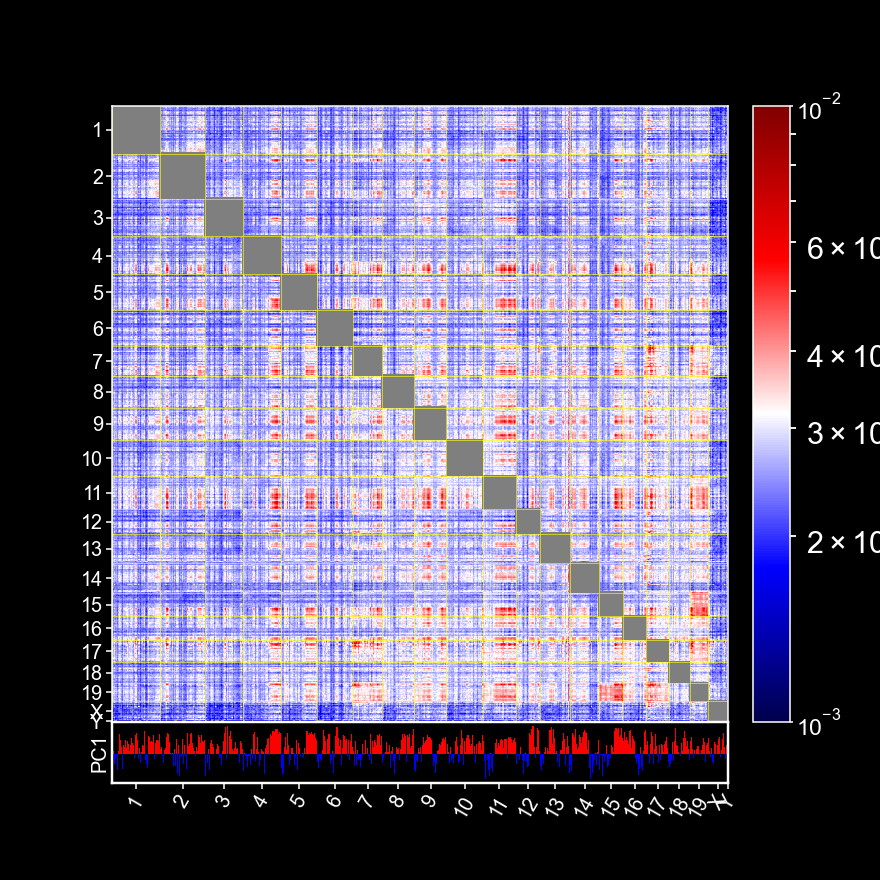

C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_35956/3569122961.py:11: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  current_cmap.set_bad(color=[0.5,0.5,0.5,1])


In [24]:
from matplotlib import cm
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.style.use('dark_background')
#plt.style.use('default')
fig, ax1 = plt.subplots(figsize=(4,4), dpi=200)

# create a color map
current_cmap = cm.get_cmap('seismic')
current_cmap.set_bad(color=[0.5,0.5,0.5,1])

vmin,vmax = 1e-3, 1e-2

_pf = ax1.imshow(_mat, 
                 cmap=current_cmap, norm=LogNorm(vmin=vmin, vmax=vmax, ))

ax1.set_yticks((_chr_edges[1:] + _chr_edges[:-1])/2,)
ax1.set_yticklabels(_chr_names,)

#                                              ticks=
#                                              tick_labels=_chr_names,

ax1.hlines(_chr_edges-0.5, 0, len(_mat), color='yellow', linewidth=0.2)
ax1.vlines(_chr_edges-0.5, 0, len(_mat), color='yellow', linewidth=0.2)
ax1.xaxis.set_tick_params(which='both', labelbottom=True)
ax1.yaxis.set_tick_params(which='both', labelleft=True)
ax1.set_xlim([0, len(_mat)])
ax1.set_ylim([len(_mat), 0])

ax1.tick_params('both', labelsize=_font_size-1, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=True, labelbottom=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax1.spines.items()]

# locate ax1
divider = make_axes_locatable(ax1)
# colorbar ax
cax = divider.append_axes('right', size='6%', pad="4%")
cbar = plt.colorbar(_pf,cax=cax, ax=ax1, ticks=[vmin,vmax])
cbar.ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=False) # remove bottom ticklabels for ax1
cbar.outline.set_linewidth(_ticklabel_width)
cbar.set_label('Pearson correlation', 
               fontsize=_font_size, labelpad=0, rotation=270)

# create bottom ax
bot_ax = divider.append_axes('bottom', size='10%', pad="0%", 
                             sharex=ax1, xticks=[])
bot_ax.bar(ensemble_AB_dict['A'], normed_pc_vals[ensemble_AB_dict['A']]-AB_th, color='r',width=1, bottom=0)
bot_ax.bar(ensemble_AB_dict['B'], normed_pc_vals[ensemble_AB_dict['B']]-AB_th, color='b',width=1, bottom=0)

bot_ax.set_xticks((_chr_edges[1:] + _chr_edges[:-1])/2,)
bot_ax.set_xticklabels(_chr_names, rotation=60)
bot_ax.tick_params('x', labelsize=_font_size-1, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=False, labelbottom=True) # remove bottom ticklabels for ax1
bot_ax.tick_params('y', labelsize=_font_size-1, 
                width=_ticklabel_width, length=0,
                pad=1, labelleft=False, labelbottom=True) # remove bottom ticklabels for ax1
bot_ax.set_ylabel('PC1', fontsize=_font_size-1, labelpad=1)
#bot_ax.set_ylim([-10,10])
#bot_ax.set_yticks([0.5,-0.5])
#bot_ax.set_yticklabels(["A","B"])
fig.savefig(os.path.join(comp_figure_folder, f"trans_contact_AB.png"),
            transparent=True)

In [26]:
subclass_2_normedMat = {}
subclass_2_corrMat = {}
subclass_2_normedPC1 = {}

for _subclass, _contactDict in subclass_2_contactDict.items():
    print(_subclass)
    # assemble matrix based on codebook
    _subclass_mat, _, _ = distance.assemble_ChrDistDict_2_Matrix(
        _contactDict, codebook, use_cis=False, use_trans=False, sort_by_region=False)
    # normalize subclass_mat
    _normed_subclass_mat = _subclass_mat.copy()
    chr_2_meanContact = {}
    for _chr,_inds in chr_2_indices.items():
        chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])
        _normed_subclass_mat[_inds] *= 1 / chr_2_meanContact[_chr]
        _normed_subclass_mat[:,_inds] *= 1 / chr_2_meanContact[_chr]
    _normed_subclass_mat = _normed_subclass_mat / np.nanmean(_normed_subclass_mat)
    # merge the normed mat
    _merged_normed_mat = np.concatenate([_normed_mat, _normed_subclass_mat]).transpose()
    # correlation
    _merged_mat_corr_df = pd.DataFrame(_merged_normed_mat).corr()
    # norm corr_mat
    _merged_corr_mat = _merged_mat_corr_df.values
    _merged_corr_mat[np.diag_indices(len(_merged_corr_mat))] = np.nan
    #
    _sel_sub_corr_mat = _merged_corr_mat[1956:,:1956][:-1,:-1]
    _ft_sub_corr_mat = convolve(_sel_sub_corr_mat, Gaussian2DKernel(contact_gaussian_sigma))
    # calculate PC
    sub_pcs = contact_model.fit_transform(_ft_sub_corr_mat)

    # normalize pc1 values
    sub_pc_vals = sub_pcs[:,0].copy()
    normed_sub_pc_vals = sub_pc_vals.copy()
    # normalize pcval
    for _chr, _inds in chr_2_indices.items():
        if _chr == 'Y':
            continue
        normed_sub_pc_vals[_inds] = normed_sub_pc_vals[_inds] - np.nanmean(sub_pc_vals[_inds])
    normed_sub_pc_vals = normed_sub_pc_vals / np.std(normed_sub_pc_vals)
    # append
    subclass_2_normedMat[_subclass] = _normed_subclass_mat
    subclass_2_corrMat[_subclass] = _ft_sub_corr_mat
    subclass_2_normedPC1[_subclass] = normed_sub_pc_vals

Astro


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_35956/655319925.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


Endo-PVM


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_35956/655319925.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


L2/3 IT


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_35956/655319925.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


L4/5 IT


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_35956/655319925.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


L5 ET


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_35956/655319925.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


L5 IT


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_35956/655319925.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


L5/6 NP


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_35956/655319925.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


L6 CT


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_35956/655319925.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


L6 IT


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_35956/655319925.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


L6b


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_35956/655319925.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


Lamp5


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_35956/655319925.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


Micro


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_35956/655319925.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


OPC


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_35956/655319925.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


Oligo


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_35956/655319925.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


Peri


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_35956/655319925.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


Pvalb


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_35956/655319925.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


SMC
Sncg


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_35956/655319925.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


Sst


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_35956/655319925.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


VLMC


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_35956/655319925.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


Vip


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_35956/655319925.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


<IPython.core.display.Javascript object>


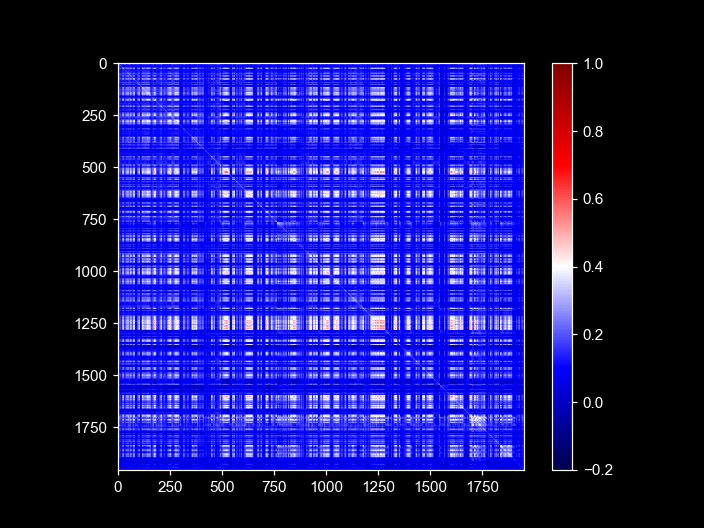

In [28]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots()
_pf = ax.imshow(subclass_2_corrMat['Astro'], vmin=-0.2, vmax=1, cmap='seismic')
plt.colorbar(_pf)

In [31]:
ens_A = ensemble_AB_dict['A']
ens_B = ensemble_AB_dict['B']

<IPython.core.display.Javascript object>


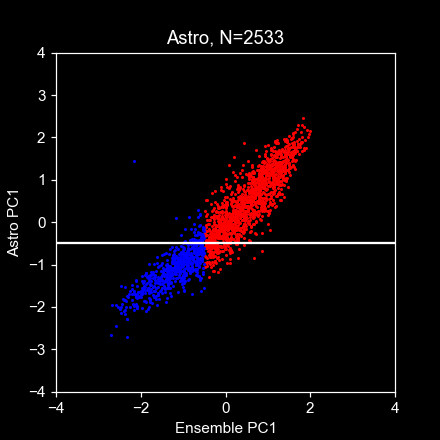

<IPython.core.display.Javascript object>


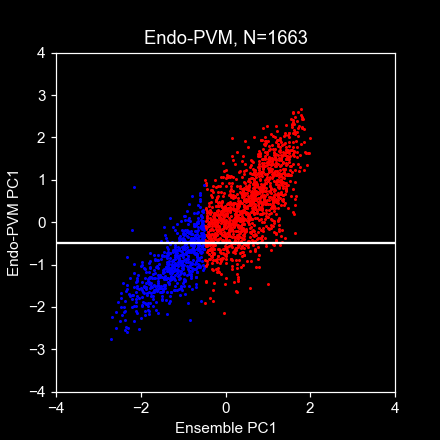

<IPython.core.display.Javascript object>


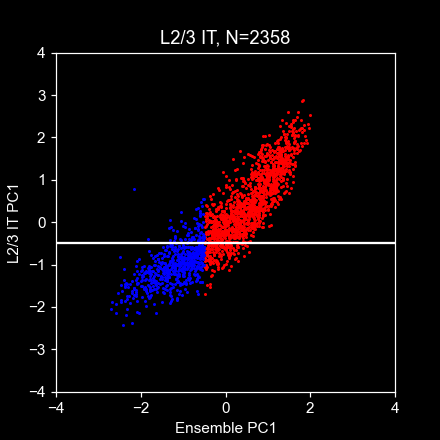

<IPython.core.display.Javascript object>


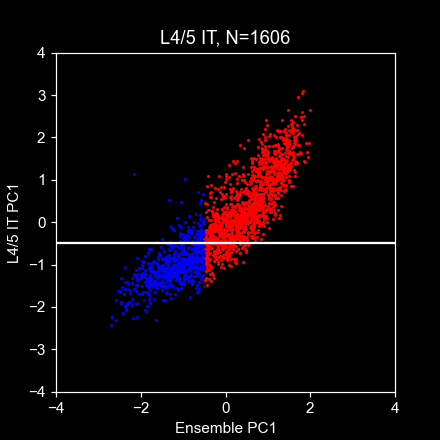

<IPython.core.display.Javascript object>


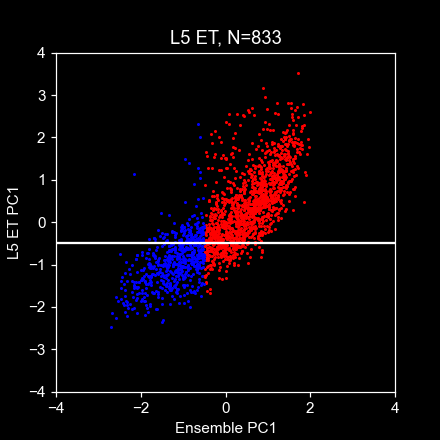

<IPython.core.display.Javascript object>


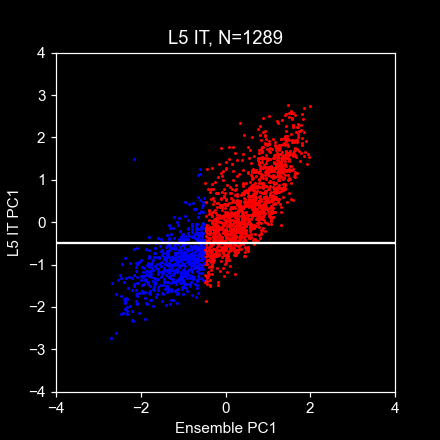

<IPython.core.display.Javascript object>


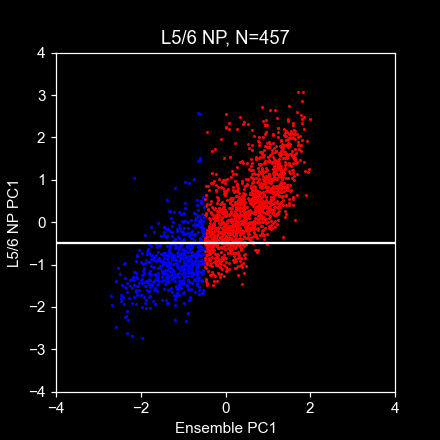

<IPython.core.display.Javascript object>


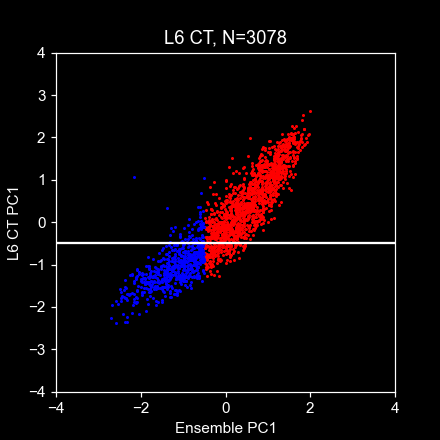

<IPython.core.display.Javascript object>


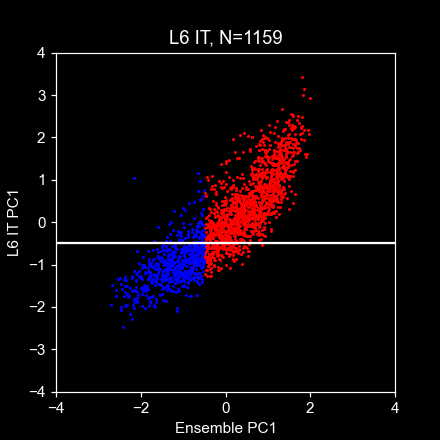

<IPython.core.display.Javascript object>


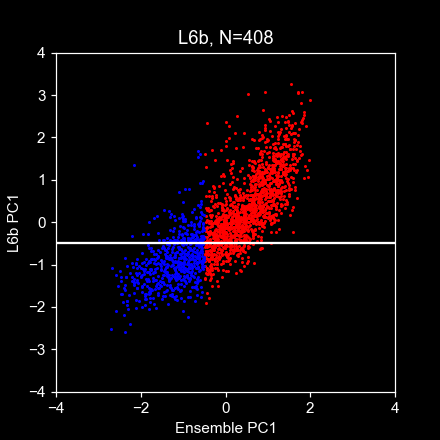

<IPython.core.display.Javascript object>


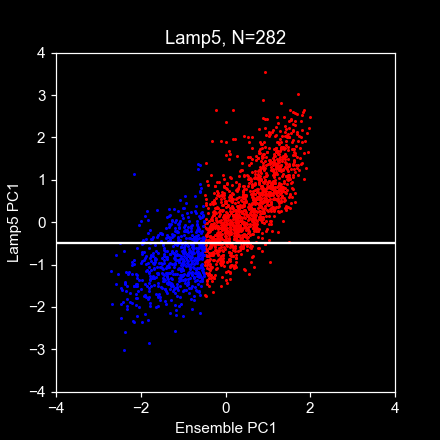

<IPython.core.display.Javascript object>


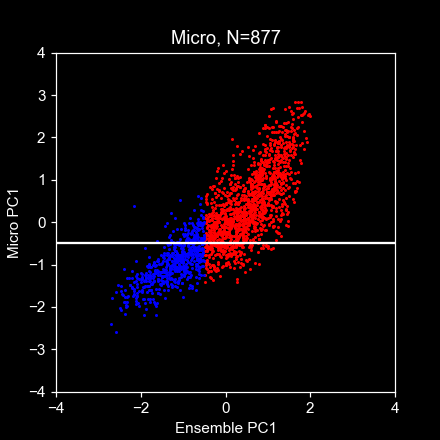

<IPython.core.display.Javascript object>


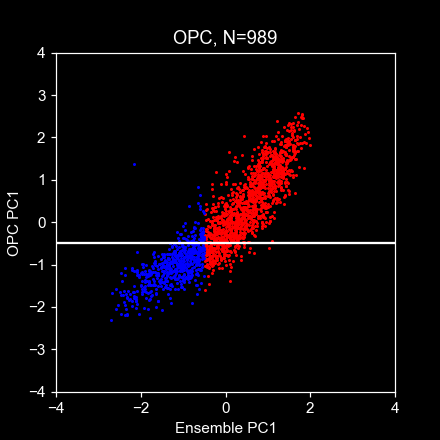

<IPython.core.display.Javascript object>


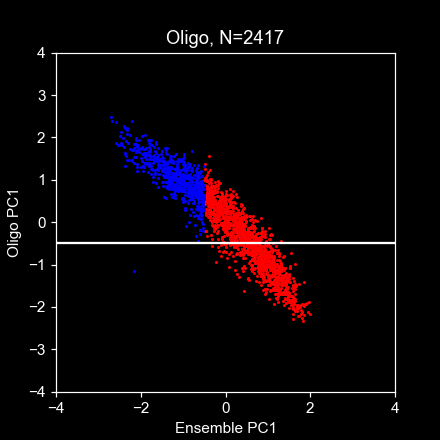

<IPython.core.display.Javascript object>


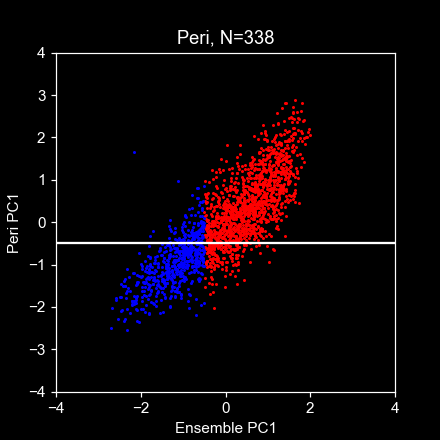

<IPython.core.display.Javascript object>


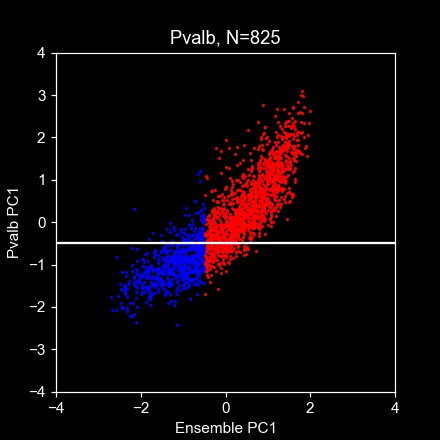

<IPython.core.display.Javascript object>


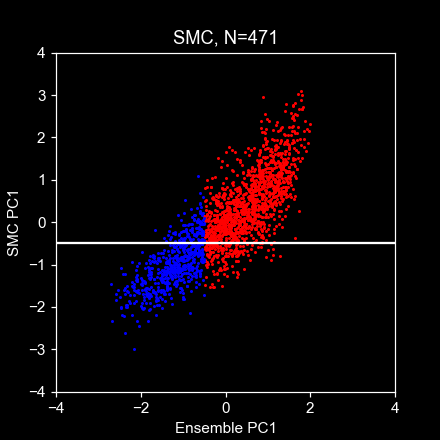

<IPython.core.display.Javascript object>


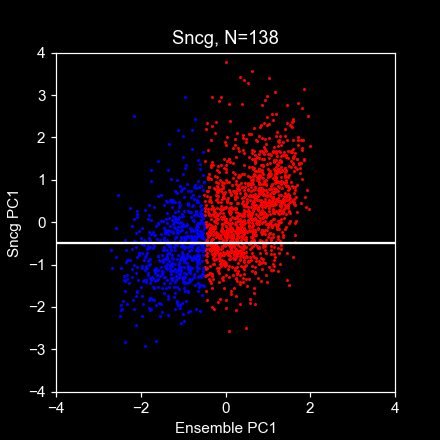

<IPython.core.display.Javascript object>


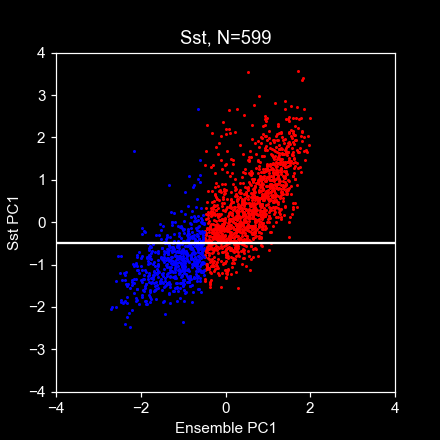

C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_35956/2407439462.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots(figsize=(4,4),dpi=100)


<IPython.core.display.Javascript object>


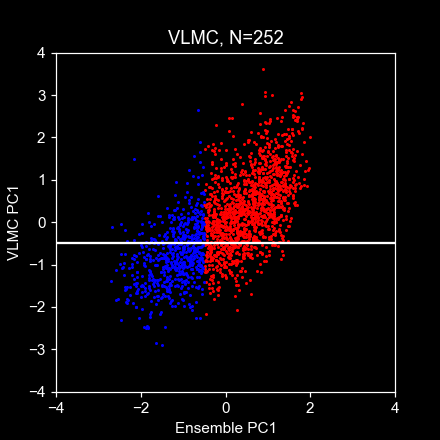

<IPython.core.display.Javascript object>


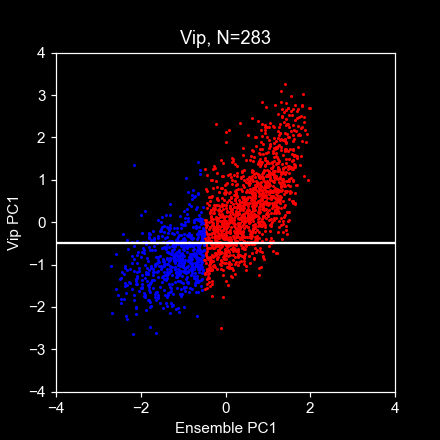

In [33]:
#sel_subclass = 'Astro'
for sel_subclass in subclass_2_normedPC1:
    fig,ax = plt.subplots(figsize=(4,4),dpi=100)
    ax.scatter(normed_pc_vals[ens_A], subclass_2_normedPC1[sel_subclass][ens_A], s=1, c='r')
    ax.scatter(normed_pc_vals[ens_B], subclass_2_normedPC1[sel_subclass][ens_B], s=1, c='b')
    ax.set_xlabel('Ensemble PC1')
    ax.set_ylabel(f"{sel_subclass} PC1")
    ax.set_ylim([-4,4])
    ax.set_xlim([-4,4])
    ax.hlines(test_AB_th, -4,4)
    ax.set_aspect('equal')
    ax.set_title(f"{sel_subclass}, N={len(class_2_zxysDict[sel_subclass])}")
    fig.show()

In [35]:
subclass_2_normedPC1['ensemble'] = normed_pc_vals

In [ ]:
test_AB_th = -0.5

<IPython.core.display.Javascript object>


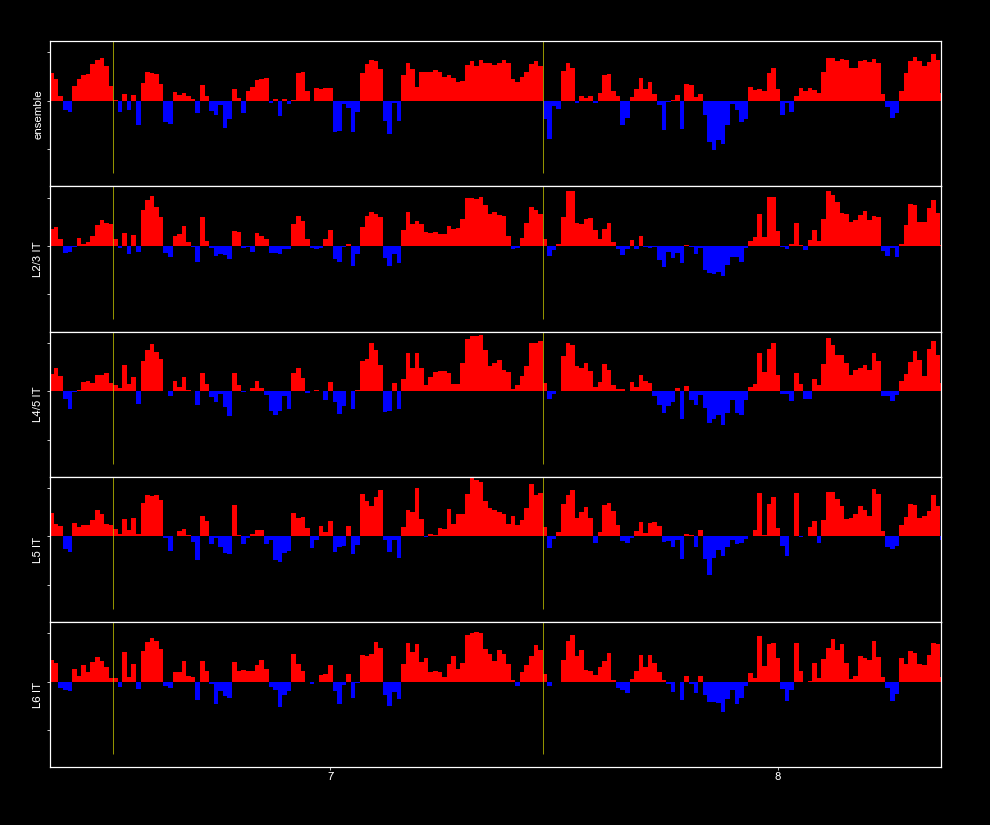

In [36]:
#nonNeu_subclasses = ['Oligo','Astro','Endo-PVM','Micro', 'OPC']
#nonNeu_subclasses = ['Oligo','Astro','L2/3 IT', 'L5 ET']
ITNeu_subclasses = ["ensemble", "L2/3 IT", 'L4/5 IT', 'L5 IT', 'L6 IT']
im_size = 1.5
_font_size = 7.5
sel_subclasses = ITNeu_subclasses

num_x = len(sel_subclasses)
fig, axes = plt.subplots(num_x, 1, figsize=(im_size*6,num_x*im_size), 
                         sharex=True, sharey=True, dpi=100)
for _i, _subclass in enumerate(sel_subclasses):
    _normedPC1 = subclass_2_normedPC1[_subclass]
    _ax = axes[_i]
    _ax.vlines(_chr_edges-0.5, -3, 3, color='y', linewidth=0.5)
    _subclass_A = np.where(_normedPC1 >= test_AB_th)[0]
    _subclass_B = np.where(_normedPC1 < test_AB_th)[0]
    # bar
    _ax.bar(_subclass_A, _normedPC1[_subclass_A]-test_AB_th, color='r',width=1, bottom=0)
    _ax.bar(_subclass_B, _normedPC1[_subclass_B]-test_AB_th, color='b',width=1, bottom=0)
    _ax.set_ylabel(f"{_subclass}", fontsize=_font_size)
    _ax.tick_params('both', labelsize=_font_size, 
                    width=_ticklabel_width, length=_ticklabel_size,
                    labelleft=False,
                    pad=1, ) # remove bottom ticklabels for ax1
# set axes
_ax.set_ylim([-3,3])
_ax.set_xlim([-0.5, len(_mat)+0.5])
_ax.set_xticks((_chr_edges[1:] + _chr_edges[:-1])/2,)
_ax.set_xticklabels(_chr_names,)

_ax.set_xlim([chr_2_indices['7'].min(), chr_2_indices['8'].max()])

fig.subplots_adjust(wspace=0.2, hspace=0., left=0.05, right=0.95, top=0.95, bottom=0.07)
fig.show()

## save

In [42]:
subclass_2_normedPC1_filename = os.path.join(postanalysis_folder, 'subclass_2_normedPC1.pkl')
if not os.path.exists(subclass_2_normedPC1_filename):
    print(f"saving: {subclass_2_normedPC1_filename}")
    pickle.dump(subclass_2_normedPC1, open(subclass_2_normedPC1_filename, 'wb'))
#subclass_2_normed_pc1 = subclass_2_normedPC1

subclass_2_normedMat_filename = os.path.join(postanalysis_folder, 'subclass_2_normedMat.pkl')
if not os.path.exists(subclass_2_normedMat_filename):
    print(f"saving: {subclass_2_normedMat_filename}")
    pickle.dump(subclass_2_normedMat, open(subclass_2_normedMat_filename, 'wb'))
#subclass_2_normed_pc1 = subclass_2_normedMat

subclass_2_corrMat_filename = os.path.join(postanalysis_folder, 'subclass_2_corrMat.pkl')
if not os.path.exists(subclass_2_corrMat_filename):
    print(f"saving: {subclass_2_corrMat_filename}")
    pickle.dump(subclass_2_corrMat, open(subclass_2_corrMat_filename, 'wb'))
#subclass_2_normed_pc1 = subclass_2_normedMat

saving: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis\subclass_2_normedPC1.pkl


### subclass specific pc1

In [43]:
import pandas as pd

In [48]:
pc1_df = pd.DataFrame(subclass_2_normedPC1)
pc1_df[['name','id']] = codebook[['name','id']]
pc1_df

,Astro,Endo-PVM,L2/3 IT,L4/5 IT,L5 ET,L5 IT,L5/6 NP,L6 CT,L6 IT,L6b,...,Peri,Pvalb,SMC,Sncg,Sst,VLMC,Vip,ensemble,name,id
0,-1.516126,-1.131327,-1.397264,-1.152120,-0.793570,-0.821764,-0.231647,-1.422480,-1.077529,0.106431,...,-1.302171,-1.670861,-1.335208,-0.311186,-1.187376,-1.761836,-1.164876,-1.680414,1:3740000-3760000,1
1,-1.054034,-0.518850,-1.708982,-1.409694,-0.951517,-1.162125,-0.511412,-1.193526,-1.113983,-0.870392,...,-0.663898,-1.696274,-0.854107,-1.077069,-1.522037,-0.145827,-0.135031,-1.303159,1:6240000-6260000,2
2,-0.441709,0.147207,-0.955076,-0.399374,0.131351,-0.628068,0.094333,-1.033082,-0.597711,-0.363623,...,0.259863,-0.930179,0.057579,0.344500,-0.216763,-0.019584,-0.054639,-0.301713,1:8740000-8760000,3
3,-0.725261,-0.358762,-0.783126,-0.881028,-0.771391,-0.579483,-0.608003,-0.922470,-0.950274,-0.838391,...,-1.037560,-1.435229,-0.414875,0.956834,-0.972619,-0.311715,-0.282000,-0.517161,1:11240000-11260000,4
4,-0.316078,-0.086843,-0.566880,-0.474032,-0.264111,-0.339712,-0.358947,-0.794266,-0.902881,-0.372900,...,-0.783448,-0.277058,-0.364671,-0.732696,-0.244457,0.153065,-0.374217,-0.256001,1:13740000-13760000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1950,0.262913,0.426605,-0.355482,-0.094638,0.804026,-0.160730,-0.147920,-0.312861,0.142598,0.280435,...,-0.101048,0.252489,-0.397224,-1.399791,0.282493,-0.958380,0.350469,0.261431,X:98979231-99088826,2048
1951,0.192867,-0.385447,0.091973,-0.191112,0.018375,0.072491,-0.394300,0.138216,-0.281203,0.179562,...,-0.102482,-0.152104,-0.779836,-0.249355,-0.480672,-0.319994,0.245620,0.286695,X:101910335-102015609,2049
1952,-0.190279,0.500784,-0.279676,0.279419,-0.591111,-0.240290,-0.132229,0.155194,-0.101208,-0.102978,...,-0.326934,0.213574,0.399372,-0.890150,0.919150,0.631052,-0.019689,0.353423,X:136772307-136851006,2050
1953,-0.727413,-0.325693,-0.321873,-0.053674,-1.454499,-0.412963,0.350885,-0.120811,-0.304057,-0.189705,...,-0.097014,0.337897,-0.048242,-0.155168,-0.031836,0.468955,-0.323167,-0.506626,X:140481839-140547985,2051


In [50]:
pc1_df.to_csv(subclass_2_normedPC1_filename.replace('.pkl', '.csv'), index=None)